# Explore Dataset: Polyp Segmentation Dataset

[source](https://www.kaggle.com/datasets/shuvoalok/cvc-clinicdb)

Inventory, validate, and explore dataset files.  Shoot, this is a SMALL dataset... it'll need augmentation.

In [22]:
import sys

sys.path.append('../src')

import snek_utils as snu

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import tifffile as tif

from typing import List

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
# Specify the directory path you want to start from
directory_path = Path('D:/Downloads/Datasets/archive')
paths = snu.list_files_pathlib(directory_path)

len(paths), paths[:5]

(1225,
 ['D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/1.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/10.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/100.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/101.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/102.tif'])

In [3]:
all_files = pd.DataFrame()

all_files['filepaths'] = paths
all_files['filename'] = [Path(x).name for x in paths]
all_files['filetype'] = [Path(x).suffix.replace('.','').lower() for x in paths]
all_files['directory'] = [x.split('/')[-2] for x in paths]

all_files.info()
all_files.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  1225 non-null   object
 1   filename   1225 non-null   object
 2   filetype   1225 non-null   object
 3   directory  1225 non-null   object
dtypes: object(4)
memory usage: 38.4+ KB


,filepaths,filename,filetype,directory
0,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,1.tif,tif,Ground Truth
1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,10.tif,tif,Ground Truth
2,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,100.tif,tif,Ground Truth
3,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,101.tif,tif,Ground Truth
4,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,102.tif,tif,Ground Truth


In [4]:
print(all_files['directory'].value_counts(), '\n')

print(all_files['filetype'].value_counts())

directory
Ground Truth    612
Original        612
CVC-ClinicDB      1
Name: count, dtype: int64 

filetype
tif    1224
txt       1
Name: count, dtype: int64


## Check out the README

In [5]:
all_files[all_files['filetype'] == 'txt']

,filepaths,filename,filetype,directory
1224,D:/Downloads/Datasets/archive/CVC-ClinicDB/REA...,README.txt,txt,CVC-ClinicDB


In [6]:
readme = all_files.at[1224, 'filepaths']

print(readme, '\n')

with open(readme, 'r') as file:
    # Read the content of the file
    file_content = file.read()
    
    # Print the content
    print('File Content:\n', file_content)

D:/Downloads/Datasets/archive/CVC-ClinicDB/README.txt 

File Content:
 CVC-ClinicDB

--------------------------------------------------
Introduction
--------------------------------------------------

CVC-ClinicDB is a database of frames extracted from colonoscopy videos. 
These frames contain several examples of polyps. In addition to the frames, we provide the ground truth for the polyps. 
This ground truth consists of a mask corresponding to the region covered by the polyp in the image.

CVC-ClinicDB has been generated from 25 different video studies. For each study at least a sequence containing a polyp was extracted. Considering this, CVC-ClinicDB database is composed by frames from 29 different sequences containing a polyp. 

Finally, a set of frames were selected from each sequence, paying particular attention in showing several points of view of the polyp. 

--------------------------------------------------
Description
--------------------------------------------------

The da

## Image time

In [12]:
# Validate filename matching

df = all_files[all_files['filetype'] == 'tif']

gt = df[df['directory'] == 'Ground Truth']
gt = gt.sort_values(by='filename').reset_index(drop=True)

imgs = df[df['directory'] != 'Ground Truth'].reset_index(drop=True)
imgs = imgs.sort_values(by='filename').reset_index(drop=True)

assert list(gt['filename']) == list(imgs['filename'])

gt.info()
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  612 non-null    object
 1   filename   612 non-null    object
 2   filetype   612 non-null    object
 3   directory  612 non-null    object
dtypes: object(4)
memory usage: 19.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  612 non-null    object
 1   filename   612 non-null    object
 2   filetype   612 non-null    object
 3   directory  612 non-null    object
dtypes: object(4)
memory usage: 19.3+ KB


D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/1.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/1.tif


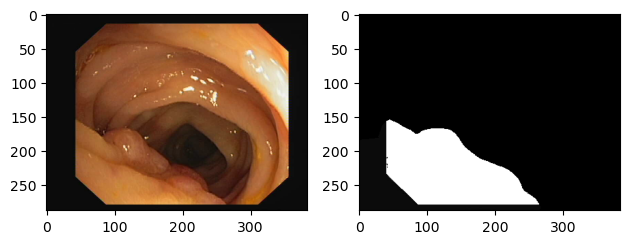

In [27]:
i = 0

gt_pth = gt.at[i, 'filepaths']
gt_im = tif.imread(gt_pth)

im_pth = imgs.at[i, 'filepaths']
im = tif.imread(im_pth)

print(gt_pth)
print(im_pth)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(gt_im, cmap='gray')

plt.tight_layout()
plt.show()